## Assignment 3

- Joel Oliveira - 59442
- João Braz - 60419

### Problem 2

In [1]:
import numpy as np

from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
X = load_breast_cancer().data
y = load_breast_cancer().target

In [3]:
X.shape

(569, 30)

In [4]:
X, X_unseen, y, y_unseen = train_test_split(X, y, test_size=0.2, random_state=0)

In [5]:
X.shape, X_unseen.shape

((455, 30), (114, 30))

In [6]:
class EnsembleAverage:
    """
    asdf
    """
    def __init__(self, 
                experts: list,
                scaler=MinMaxScaler()
    ):
        """
        asd
        """
        self.n_models = len(experts)
        self.experts = experts
        self.weights = np.zeros(self.n_models)
        self.scaler=scaler
        self.cv_scores = []
    
    
    def fit(self, X, y, shuffle=False):
        """
        
        """
        for i in range(self.n_models):
            score = self.cv_score(
                self.experts[i], 
                X, 
                y, 
                cv=5,
                shuffle=shuffle
            )
            self.cv_scores.append(score)
            score = score.mean()
            self.weights[i] = score
            model = self.experts[i].fit(
                self.scaler.fit_transform(X),
                y
            )
        self.scaler.fit(X)
        return self
        
        
    def predict(self, X) -> list:
        """
        
        """
        X_scaled = self.scaler.transform(X)
        preds = np.array([ model.predict(X_scaled) for model in self.experts])
        pred = np.round( self.get_gate() @ preds )
        return pred
    
    
    def get_params(self, deep) -> dict:
        """
        
        """
        return {
            "experts" : self.experts,
            "scaler": self.scaler
        }
    
    
    def __softmax(self, W):
        """
        
        """
        return np.exp(W) / np.exp(W).sum()
    
    
    def get_gate(self):
        """
        
        """
        return self.__softmax(self.weights)
    
    
    def cv_score(self, model, X, y, cv=5, shuffle=False):
        """
        
        """
        N = np.ceil(X.shape[0] / cv).astype(int)
        
        if shuffle:
            idx_shuffled = list(range(X.shape[0]))
            np.random.shuffle(idx_shuffled)
            X = X[idx_shuffled]
            y = y[idx_shuffled]
        
        cv_results = []
        for i in range(cv):            
            train_idx_left = slice( max(0, (i-1) )*N, i*N )
            train_idx_rigth = slice( (i+1)*N, None )
            test_idx = slice(i*N, (i+1)*N)
            
            
            x_train_left, y_train_left = X[ train_idx_left], y[train_idx_left ]
            x_train_rigth, y_train_rigth = X[ train_idx_rigth ], y[train_idx_rigth ]
            
            x_train = np.concatenate((x_train_left, x_train_rigth))
            y_train = np.concatenate((y_train_left, y_train_rigth))
            x_test, y_test = X[ test_idx ], y[test_idx]
            
            self.scaler.fit(x_train)
            x_train_scaled = x_train#self.scaler.transform(x_train)
            x_test_scaled = x_test#self.scaler.transform(x_test)
            
            model.fit(x_train_scaled, y_train)
            cv_results.append( 
                accuracy_score( 
                    y_test, 
                    model.predict(x_test_scaled) 
                ) 
            )
            
        return np.array(cv_results)
            
                 

In [7]:
model = EnsembleAverage(
    experts=[
        DecisionTreeClassifier(criterion="entropy"),
        DecisionTreeClassifier(),
    ],
    #scaler=StandardScaler()
).fit(X, y)

In [8]:
print(model.weights)
print(model.get_gate())
print(model.weights.mean())

[0.90989011 0.91648352]
[0.49835165 0.50164835]
0.9131868131868132


In [9]:
model = EnsembleAverage(
    experts=[
        SVC(kernel="linear"),
        SVC(kernel="poly"),
        SVC()
    ],
    scaler=StandardScaler()
).fit(X, y)

In [10]:
print(model.weights)
print(model.get_gate())
print(model.weights.mean())

[0.95164835 0.9032967  0.9032967 ]
[0.34416331 0.32791835 0.32791835]
0.9194139194139194


In [11]:
model = EnsembleAverage(
    experts=[
        DecisionTreeClassifier(),
        GaussianNB(),
        LogisticRegression(max_iter=99999)
    ],
    #scaler=StandardScaler()
).fit(X, y)

In [12]:
print(model.weights)
print(model.get_gate())
print(model.weights.mean())

[0.9010989  0.93626374 0.96043956]
[0.32290072 0.33445748 0.3426418 ]
0.9326007326007325


In [13]:
model = EnsembleAverage(
    experts=[
        DecisionTreeClassifier(),
        SVC(kernel="linear"),
        KNeighborsClassifier(),
        GaussianNB(),
    ],
    #scaler=StandardScaler()
).fit(X, y)

In [14]:
print(model.weights)
print(model.get_gate())
print(model.weights.mean())

[0.90549451 0.95164835 0.91648352 0.93626374]
[0.24452672 0.25607707 0.24722865 0.25216757]
0.9274725274725274


In [15]:
model = EnsembleAverage(
    experts=[
        SVC(kernel="linear"),
        GaussianNB(),
        LogisticRegression(max_iter=99999)
    ],
    #scaler=StandardScaler()
).fit(X, y)

In [16]:
print(model.weights)
print(model.get_gate())
print(model.weights.mean())

[0.95164835 0.93626374 0.96043956]
[0.33405008 0.32895018 0.33699973]
0.9494505494505493


In [17]:
model = EnsembleAverage(
    experts=[
        SVC(kernel="linear"),
        DecisionTreeClassifier(max_depth=15),
        LogisticRegression(max_iter=99999)
    ],
    scaler=StandardScaler()
).fit(X, y)

In [18]:
print(model.weights)
print(model.get_gate())
print(model.weights.mean())

[0.95164835 0.92527473 0.96043956]
[0.33525534 0.32652902 0.33821564]
0.9457875457875456


In [19]:
model = EnsembleAverage(
    experts=[
        SVC(kernel="linear"),
        DecisionTreeClassifier(max_depth=15),
        KNeighborsClassifier(),
        GaussianNB(),
        LogisticRegression(max_iter=99999)
    ],
    scaler=StandardScaler()
).fit(X, y)

In [20]:
print(model.weights)
print(model.get_gate())
print(model.weights.mean())

[0.95164835 0.92087912 0.91648352 0.93626374 0.96043956]
[0.2028929  0.19674511 0.19588219 0.19979536 0.20468444]
0.937142857142857


> Since all the models are having basicly the same results, we will try to use a very bad model so that the weights are not evenly split across all experts

In [21]:
def reverse_euclidean(u, v, w=None):
    return 1/np.sum( (u-v)**2 )**0.5

In [22]:
model = EnsembleAverage(
    experts=[
        KNeighborsClassifier(metric=reverse_euclidean),
        SVC(kernel="linear"),
        GaussianNB(),
        LogisticRegression(max_iter=99999)
    ]
).fit(X, y, True)

In [23]:
print(model.weights)
print(model.get_gate())
print(model.weights.mean())

[0.23296703 0.94065934 0.94945055 0.95164835]
[0.14028688 0.28468457 0.28719832 0.28783022]
0.7686813186813186


### Performance on Test Set

We selected the model that obtained, on average, better performance in the Cross-validation performed on the training set

In [24]:
model = EnsembleAverage(
    experts=[
        SVC(kernel="linear"),
        GaussianNB(),
        LogisticRegression(max_iter=99999)
    ],
    scaler=StandardScaler()
).fit(X, y, False)

In [25]:
model.weights

array([0.95164835, 0.93626374, 0.96043956])

0.9649122807017544
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        47
           1       0.97      0.97      0.97        67

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114



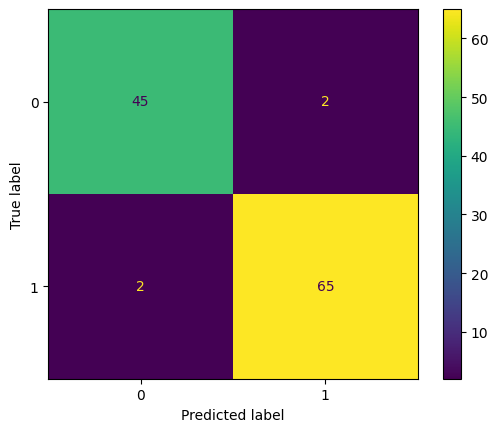

In [26]:
preds = model.predict(X_unseen)
print(accuracy_score(y_unseen, preds))

print(classification_report(y_unseen, preds))

ConfusionMatrixDisplay(
    confusion_matrix(y_unseen, preds)
).plot()

> Great accuracy, precision and recall values obtained. 

In [27]:
print("Ensemble accuracy = ", accuracy_score(y_unseen, model.predict(X_unseen)))

for i,m in enumerate(model.experts, start=1):
    print(f"Model Nº {i} accuracy = {accuracy_score( y_unseen, m.predict( model.scaler.transform(X_unseen) ) ) }")

Ensemble accuracy =  0.9649122807017544
Model Nº 1 accuracy = 0.9824561403508771
Model Nº 2 accuracy = 0.9035087719298246
Model Nº 3 accuracy = 0.9649122807017544


Compared to the models themselves, it seems that the linear models are the ones that could best split the data. The SVM could actually obtain better accuracy than the EnsembleModel

0.9824561403508771
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        47
           1       0.99      0.99      0.99        67

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



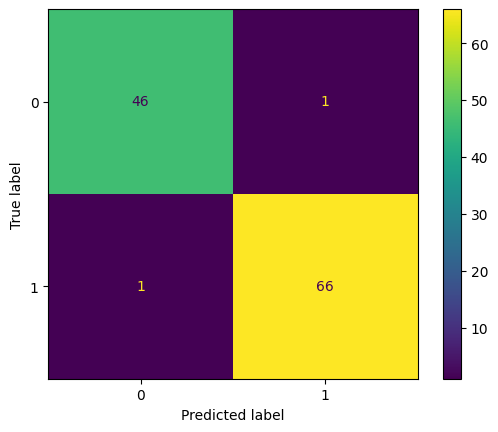

In [28]:
preds = model.experts[0].predict(
    model.scaler.transform(X_unseen)
)
print(accuracy_score(y_unseen, preds))

print(classification_report(y_unseen, preds))

ConfusionMatrixDisplay(
    confusion_matrix(y_unseen, preds)
).plot()

It also obtained better precision and better recall, having missed only two samples.

Overall both the models obtained very good results for this dataset